In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import shutil
import torch
from pathlib import Path
import pandas as pd
import numpy as np

from helper_functions.tile import tile_img
from helper_functions.stitch import stitch_labels
from helper_functions.evaluate_helpers import yolo_format_to_bbox_corners, _evaluate, _precision_recall_f1

from ultralytics import YOLO
import time

In [2]:
def predict_yolo(pred_path:str,  # folder containing all images for inference")
                 label_save_path:str, # folder to save the label txts stitched
                 weight_dir:str, # path to pre-trained model weights
                 save_tiles_path:str="tiled", # temporary folder to store tiled images 
                 conf:float=0.25, # conf threshold of model
                 save_txt:bool=True):
    
    pred_path = Path(pred_path)
    label_save_path = Path(label_save_path)


    pred_imgs = list(pred_path.glob("*.jpg")) # get all images path in pred_path

  

    for img_path in pred_imgs:
        img = cv2.imread(str(img_path))
        HEIGHT, WIDTH = img.shape[:2]

        tile_img(img=img,
                save_path=save_tiles_path)


        # use this if CLI is not working
#         device='cuda' if torch.cuda.is_available() else 'cpu'
        device='cpu' # CHANGE THIS
        model = YOLO(weight_dir) # instantiate model
        
        model.predict(source=save_tiles_path, save_txt=save_txt, exist_ok=True, conf=conf, verbose=False)
        #model.predict(source=save_tiles_path, save_txt=save_txt, exist_ok=True, save_conf=False)



        if not label_save_path.exists():
            os.makedirs(label_save_path, exist_ok=True)

        master_df = stitch_labels("./runs/detect/predict/labels",
                      HEIGHT = HEIGHT,
                      WIDTH=WIDTH)

        master_df.to_csv(str(label_save_path / img_path.name[:-4])+".txt", sep=" ", header=None, index=False) # save stitched labels 
        
        shutil.rmtree("runs")

In [3]:
conf_thres_list = [0.3]

input_paths = list(Path('stress-test-data').glob('*'))
#gt_location = 'tomatoes test'
# gt_paths = list(Path(gt_location).glob("*.txt"))


# save path of detections in tiled imgs
tile_imgs_path = 'tiled'
output_path = './runs/detect/predict/labels' 
os.makedirs(output_path, exist_ok=True)

# where to save stitched pred outputs
test_set_pred_output = Path('./test_set_preds')
os.makedirs(test_set_pred_output, exist_ok=True)

df_col_names = ['class', 'x1', 'y1', 'w', 'h'] 

idx2class = {0:'flower', 1:'leaf'}
target_class_list = [0, 1] # idx list of obj classes

# idx2class = {0:'flower', 1:'leaf', 2: 'tomato'}
# target_class_list = [0, 1, 2] # idx list of obj classes




# path to store csv results
csv_path = './csv_test_results'

In [4]:
# model_names = [path.stem for path in list(Path('yolov8_weights_notomato').glob('*')) if path.stem != '.ipynb_checkpoints']
model_names = [path.stem for path in list(Path('tomato_bed').glob('*')) if path.stem != '.ipynb_checkpoints']

model_names = [name for name in model_names if name!='previous'] # remove 'previous' folder
model_names.sort() 
model_names

['yolov8l_tomato_crop',
 'yolov8l_tomato_noaug',
 'yolov8l_tomato_rotate',
 'yolov8m_tomato_crop',
 'yolov8m_tomato_noaug',
 'yolov8m_tomato_rotate',
 'yolov8s_tomato_crop',
 'yolov8s_tomato_noaug',
 'yolov8s_tomato_rotate']

In [ ]:
model_name = 'yolov8m_tomato_rotate'
weights_dir = f'tomato_bed/{model_name}/weights/best.pt'
conf_thres = 0.5
    
for input_path in input_paths:
    num_images = len(list(input_path.glob('*.jpg')))
    
    #input_path = Path("tomatoes test")

    output_parent_dir = Path("test_set_preds")
    os.makedirs(output_parent_dir, exist_ok=True) # make folder if it doesnt existEros Hacinas


    print("Detecting objects...")
    # model prediction
    os.makedirs(output_parent_dir, exist_ok=True) # make output folder

    start_time = time.time() # start time 
    
    predict_yolo(pred_path=str(input_path),
              label_save_path=str(output_parent_dir), 
              weight_dir=weights_dir, conf=conf_thres)

    end_time = time.time() # end time
    
    execution_time = end_time - start_time
    print("Detection done.")
    
    # reset folders
    shutil.rmtree('test_set_preds')
    shutil.rmtree('tiled')

    os.makedirs('test_set_preds')
    os.makedirs('tiled')
    
    print(f'{execution_time:2f} secs. for {num_images} images')




Detecting objects...


Results saved to runs/detect/predict
8 labels saved to runs/detect/predict/labels
Results saved to runs/detect/predict
8 labels saved to runs/detect/predict/labels
Results saved to runs/detect/predict
8 labels saved to runs/detect/predict/labels


In [ ]:
shutil.rmtree('test_set_preds')
shutil.rmtree('tiled')

GPU
num of imgs / time to process
* 2 images= 11.34 secs.
* 4 images = 16.54 secs
* 8 = 28.60 secs
* 16 = 61.15 secs
* 32 = 123.01 secs

In [ ]:
GPU = [11.34, 16.54, 28.60, 61.15, 123.01]

CPU
num of imgs / time to process
* 2 images= 8.00 secs.
* 4 images =  16.96 secs
* 8 =  50.09 secs
* 16 =  57.26 secs
* 32 =  120.06 secs

In [ ]:
CPU
num of imgs / time to process
CPU = [8.00, 16.96, 50.09, 57.26, 120.06]

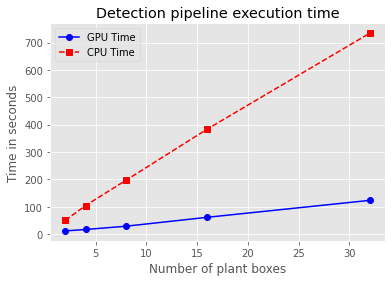

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Setting the data
NUM_ITEMS = np.array([2, 4, 8, 16, 32])
GPU_TIME = np.array([11.34, 16.54, 28.60, 61.15, 123.01])
CPU_TIME = np.array([49.65, 104.10, 196.94, 383.76, 733.96])

# Setting the plot style
plt.style.use('ggplot')

# Plotting the data
plt.plot(NUM_ITEMS, GPU_TIME, marker='o', linestyle='-', color='b', label='GPU Time')
plt.plot(NUM_ITEMS, CPU_TIME, marker='s', linestyle='--', color='r', label='CPU Time')

# Setting the title and the labels of the plot
plt.title('Detection pipeline execution time')
plt.xlabel('Number of plant boxes')
plt.ylabel('Time in seconds')

# Displaying the legend
plt.legend()

plt.savefig('stress-test-plot.jpg', dpi=300)

# Displaying the plot
plt.show()


In [13]:
plt.savefig('stress-test-plot.png', dpi=300)

<Figure size 432x288 with 0 Axes>